## K8 Services
____

+ Services
+ Services Demo
+ ClusterIP

## Setup 
___

K8s Services enables communication between various components within and outside the application

Allows us to connect applications together with other applications or with users.

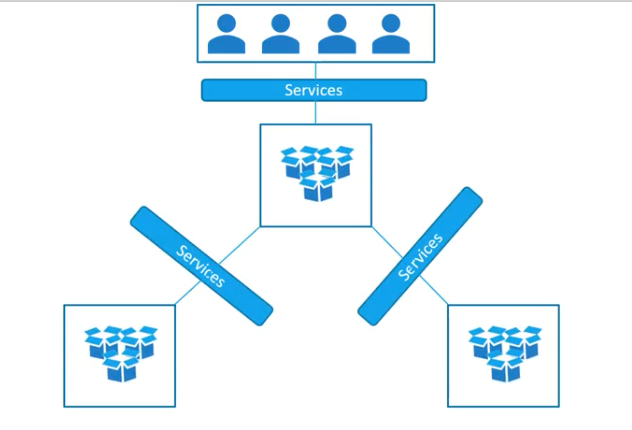


Services enable loose coupling between micro services in our application.

Remember pod communicate with each other through internal networking.

Now lets look at some other aspects of networking...

if have a web app that runs on pod, we can ssh into web app and view the app using a curl command.



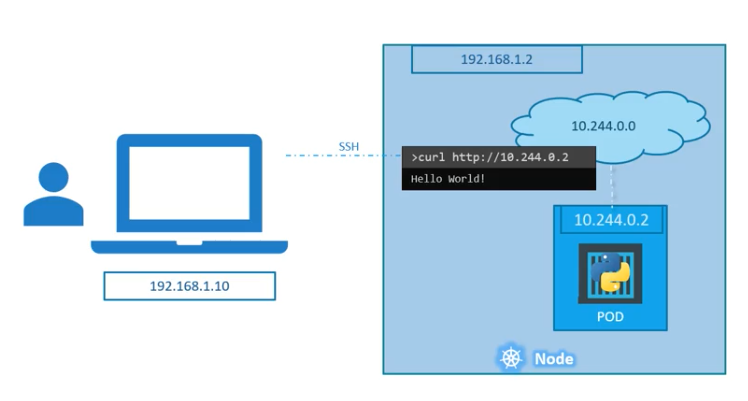


But we issing the curl command from inside the k8s node (given we on our terminal, the command is still running inside the VM). This is not ideal.

I want to be able to access the webservice from my own laptop, without having to ssh into the node, but only by accessing the ip of the k8s node

So we need something in the middle to map requests from laptop to node running the web container.

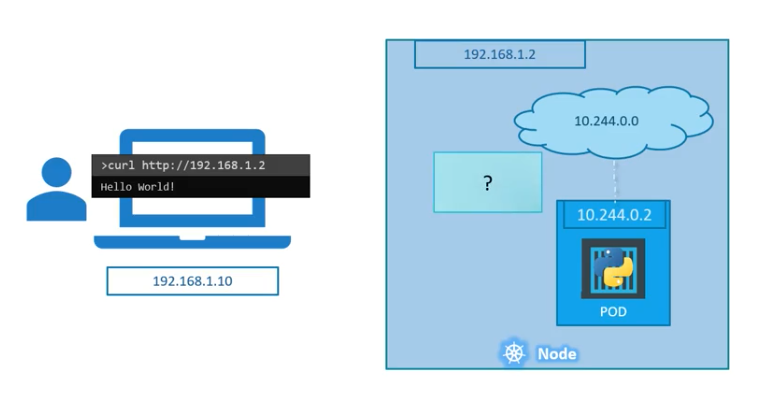

This is were the k8s Service object is been used. I is an object just like pods, replicasets or deployments that we worked with before.

One of its use cases is to listen to a port, and forward request on that port to a port running the web application.

This type of service is called a Nodeport service, since the service listens to a port on a node and forward requests to pods.

There are also other types of services, such as

1. ClusterIP. Here the service creates a virtual ip, inside the cluster to enable comms between difference services, such as front end servers to set back end servers
2. Load balancer. Here the service provisions a load balancer in our application in supported cloud providers.


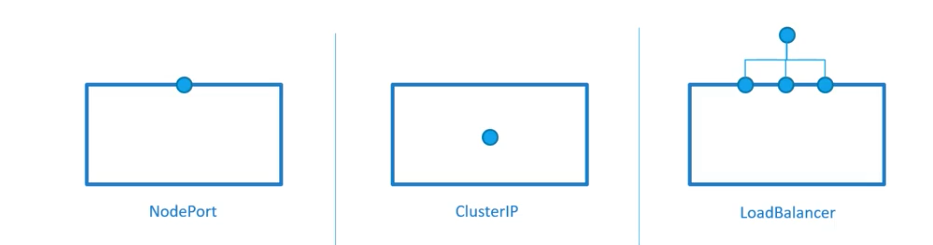







## NodePort

___

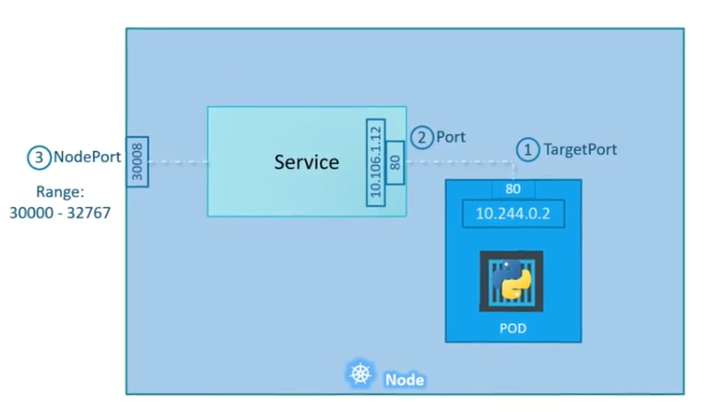


Here we havae three (3) ports involved



1. Port where the webserver is running is 80. This is the port of the POD. This is referred to as the TARGET port. Reason wht this is called the target port? This is where we want to get to, that is where the request is targeted to.
2. Second port is the port on the service object. This is just called the PORT. Remember these terms is from the service object viewpoint. The service is also a virtual server inside the node, and itside the cluster it has its own ip. This ip is the cluster ip of the service.
3. Lastly we have the port on the node (VM) itself, which we use to access the web app externally, and that is called the NODEPORT. Nodeport port valid range is from 30000 to 32767

How do we create a service?

Again here we use a definition yml file,with the four topics, with spec been the topic that differs between the other object definitions.




But there is something crucially missing from this file.

There is nothing in the definition file that connects the service to the POD...how to we solve this...we mentioned the target port but on which pod???


As we did with the replicaset earlier, we will use labels and selectors to link these together.

We have created the POD with a label, so we can use this as a identifier. So we can use this label in the service definition file.


We have a new property we can use, it is called a selector. Here we define a list of labels to identify the pod. We will refer to the pod definition file that we used to define the pod. Pull the labels from the pod def filem and place it under the labels section

```
spec:
    selector: 
        app: myapp
        type: front-end

```

Now we have linked the service to the pod.

We use the kubectl create command with the service definition file

```
kubectl create -f service-defition.yml

```

To see the service, run the kuberctl, get serices

```
kuberctl get services
```



We can now use this service, using curl or web browser FROM our laptop (using the ip of the node)

```
http://192.168.1.2:30008

```

So far we saw a service mapped to a single port:

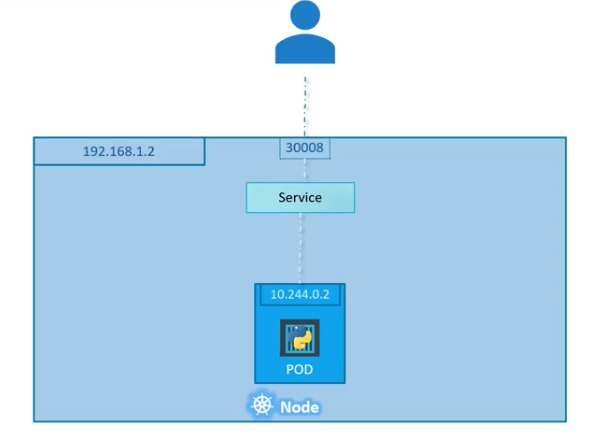


But what do we do when we have multiple pods, of the same web app???

This is the reason why we using k8s, so we can have multiple instances of the same app...

So they all have the same labels: myapp, so if there are 3 instances the services will find all 3 matching pod labels.. So the service will forward a request, and selects all 3 pods as endpoints. You dont have to do anything....You do ot have to do any additional configuration for this to happen.

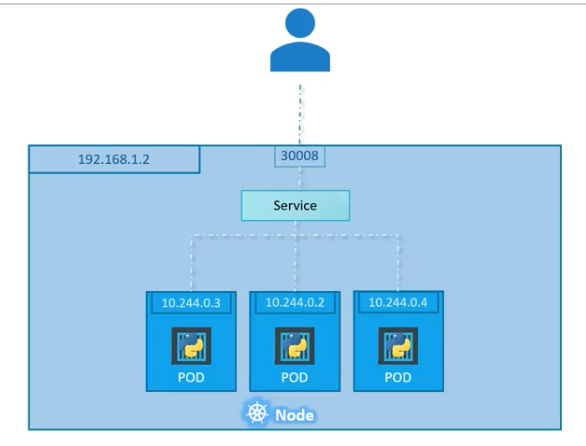

The algo it uses to balance the load is: Random algorithm(???)


So the load balancer is built into the service.

What happens when the pods are distributed acorss multiple nodes?  So wehn we create a service now, k8s created a service that spans the nodes in the cluster.We do not need to do any additional configuration. And maps the target port to the same node port (30008) on all the different node in the cluster.

So we access the we app, using any nodes ip, but with the same nodeport.


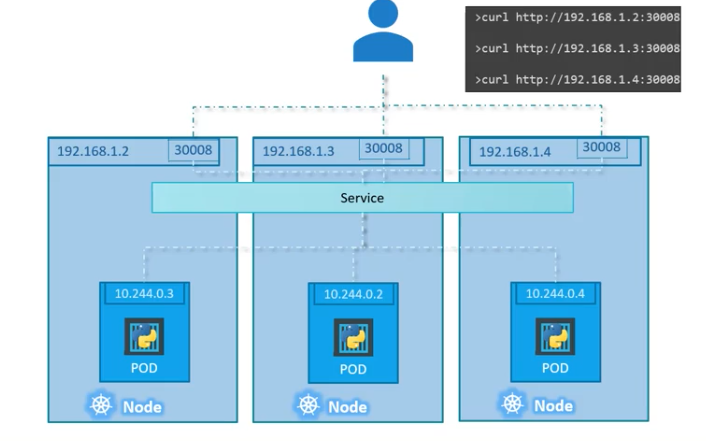

So summary, where you have the service on single instance or multinode instance, you dont need to perform any additional step when you deploy a service: K8s takes care of everything under the hood.





file
```
apiVersion: v1
kind: Service
metadata:
  name: myapp-service
spec: 
  type: NodePort
  ports:
    - nodePort: 30008
      port: 80  
      targetPort: 80
  selector:
    app: myapp
    type: front-end

```





## Services Demo

___

We will create a service to access the web app.

We create and run the following:

```
apiVersion: v1
kind: Service
metadata: 
  name: myapp-service
spec: 
  ports: 
    - 
      nodePort: 30008
      port: 80
      targetPort: 80
  selector: 
    app: myapp
    type: front-end
  type: NodePort

```

```
sudo kubectl create -f service-definition.yml --record
```

result
```
service/myapp-service created
```

get services...

```
NAME            TYPE        CLUSTER-IP       EXTERNAL-IP   PORT(S)        AGE
kubernetes      ClusterIP   10.96.0.1        <none>        443/TCP        23m
myapp-service   NodePort    10.105.198.149   <none>        80:30008/TCP   60s

```


We have a cluster ip (service ip) and the the "node's" port (30008) and port on the pod(80)

Now we can access the we app from a web browser.

Cannot connect???  ...192.168.56.3:30008 

Using curl, get error: "Connection Refused"



## ClusrerIP

___

Here we will cover the Cluster IP service type.

Remember a full stack application typically have different kinds of pods, hosting different  parts of application.


So we have a set of pods running

1. front end server
2. back end server
3. key value store like redis.

So front end servere these to communicate with back end server, and back end service need to communicate the redis server and front end service.

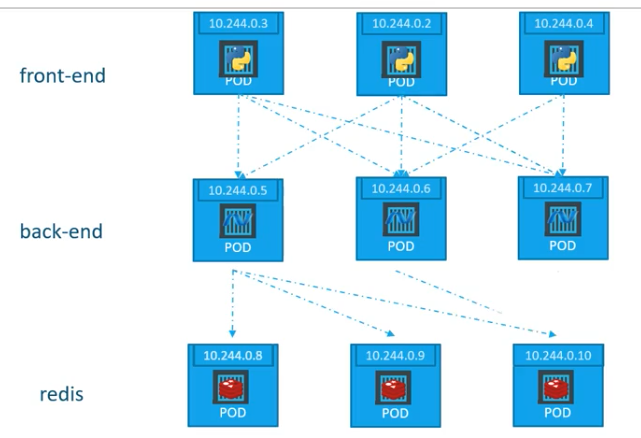

So what is the right way to establish connectivity between these components.

so the pods all have an ip assigned to them, but these ip's as we know are not static, and they can go down any time. So we cannot rely on these ip's for communication.

And what if the frontend pod (10.244.0.3) needs to connect to backend pod, who decides whoch pods to choose

A k8s service will help use group these pods together, and provide a single interface to access the pods (in the group)

So service created for back end pods, willl group all these pods together, and provide a single interface, for other pods to access the service.

A request are forwarded to one of the pods under the service randomly 


This enable us to deploy a microservices based application on k8s cluster

This type of service is called clusterIP:

1. Each layer can now scale or be removed as required, without impacting communication between the various services
2. Each service gets an ip, a name assigned to it inside the cluster, and that is the name that will be used by other pods to access the service


Again, to create such a service, we use a definition file


file: clusterservice-definition.yml
```
apiVersion: v1
kind: Service
metadata:
  name: backend-service
spec: 
  type: ClusterIP
  ports:
    - port: 80  
      targetPort: 80
  selector:
    app: myapp
    type: back-end

```

The type is cluster if ommitted, is the deault type.

The targetport is the backend port (remember this is where the request is forwarded to), and the port is where the service is exposed.

To link the ports to pod, we need selector, and copy the labels (children) from the pod definition.


And we create it using kubectl create command with the definition file


```
sudo kubectl create -f clusterservice-definition.yml

```

Now the service will be created, and using get services we get the clusterIP, which other services can use to access it.


